In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas.plotting._converter as pandacnv
pandacnv.register()

From `data/Dodgers.names`

>6. Dodgers.data file format:
> (column)
>  1.  Date: MM/DD/YY
>  2.  Time: (H)H:MM (military time)
>  3.  Count: Number of cars measured for the previous five minutes
>  Rows: Each five minute time slice is represented by one row
>
>7. Dodgers.events format:
> (column)
>  1.  Date: MM/DD/YY
>  2.  Begin event time: HH:MM:SS (military)
>  3.  End event time: HH:MM:SS (military)
>  4.  Game attendance
>  5.  Away team
>  6.  W/L score
>
>8. Missing Attribute Values: 2903 (represented by -1)

In [2]:
from os import walk

for d, _, files in walk('./data'):
    for f in files:
        print(d+'/'+f)

./data/CalIt2.names
./data/Dodgers.events
./data/CalIt2.events
./data/Dodgers.data
./data/CalIt2.data
./data/Dodgers.names


In [3]:
df = pd.read_csv('data/Dodgers.data',header=None,names=['Date', 'Count'],index_col=0)
df.index = pd.to_datetime(df.index)

We can see we are going to have some problem with the '-1' data immediately, and this is going to cause problems with the predictions.

In [4]:
def print_missed_entries(gdf):
    total_elements = len(gdf)
    num_missed = gdf.where(gdf['Count'] == -1).count()['Count']
    perc_missed = (num_missed / total_elements) * 100

    print('{} missed entries of {} total entries: {:0.2f}% missed'.format(num_missed, total_elements, perc_missed)) 

In [5]:
print_missed_entries(df)

2903 missed entries of 50400 total entries: 5.76% missed


In [6]:
# We will take the -1 at the beginning and the end to begin.
first_real_entry = df[df.Count > 0].index[0]
last_real_entry = df[df.Count > 0].index[-1]
df = df[first_real_entry:last_real_entry]

In [7]:
print_missed_entries(df)

2238 missed entries of 49735 total entries: 4.50% missed


This is a good initial drop, but we still have to deal with the embedded data points that have missing values. What we are going to do to alleviate this issue is retrieve the average car count at that particular minute over the day, and fill in those values accordingly. This should be reasonable because We are keeping a fine level of granularity and trying to keep busier minutes of the day to have more traffic.

In [8]:
min_time = df.index.min()
max_time = df.index.max()
num_five_min_ints = 12 * 24 # each day can be broken up into 12x24 = 288 5-minute-intervals

avg_score = {}
for i in range(num_five_min_ints):
    mean = df.loc[np.arange(min_time, max_time, dtype='datetime64[D]') + np.timedelta64(5*i,'m')] \
                .where(df['Count']>0).mean()['Count']
    avg_score[i] = mean

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


In [9]:
df.sum()

Count    991167
dtype: int64

In [10]:
for index, val in df.iterrows():
    if val[0] == -1:
        dt = index.to_pydatetime() 
        replace_val = int(dt.hour * 12 + dt.minute / 5)
        df.at[index,'Count'] = avg_score[replace_val]

In [11]:
df.sum()

Count    1035116
dtype: int64

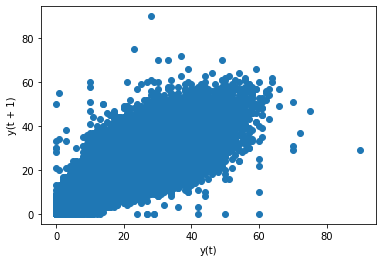

In [12]:
from pandas.plotting import lag_plot
lag_plot(df)
plt.show()

The lag plot shows that there clearly is some sort of autocorrelation between the last five minutes and the following five. This makes sense, as traffic will not change that much over the course of 5 minutes.

In [13]:
df = df['2005-04-12':'2005-09-30'] # get rid of partial days

In [14]:
df = df.groupby(df.index.date).sum()

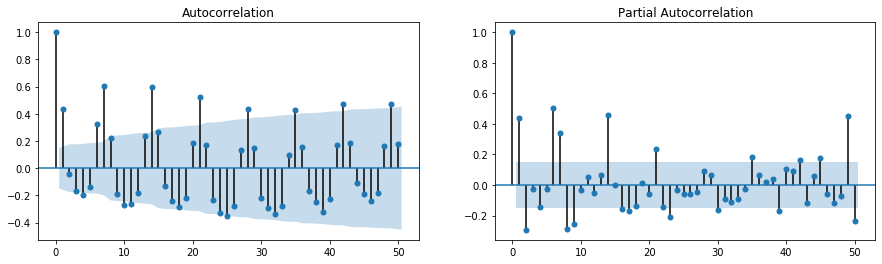

In [15]:
import statsmodels.api as sm

fig, axes = plt.subplots(1, 2, figsize=(15,4))

num_lags = 50
fig = sm.graphics.tsa.plot_acf(df['Count'], lags=num_lags, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df['Count'], lags=num_lags, ax=axes[1])

By looking at the autocorrelation plot, we immediately see there is a seasonal component to this data, which repeats approximately every week. This makes sense, because people typically follow some sort of weekly schedule. Because of this seasonality, we are going to start out modelling by creating a SARIMA model (Seasonal Autoregressive Integrated Moving Average).

In [16]:
forecast_size = 30
train, test = df['Count'][:-forecast_size], df['Count'][-forecast_size:]

# Fit the model
mod = sm.tsa.statespace.SARIMAX(train, order=(3,0,1), seasonal_order=(1,0,3,7))
res = mod.fit(disp=False)

print(res.summary())

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                
Dep. Variable:                             Count   No. Observations:                  142
Model:             SARIMAX(3, 0, 1)x(1, 0, 3, 7)   Log Likelihood               -1068.167
Date:                           Wed, 16 Oct 2019   AIC                           2154.334
Time:                                   16:13:31   BIC                           2180.937
Sample:                               04-12-2005   HQIC                          2165.144
                                    - 08-31-2005                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5462      0.072     21.579      0.000       1.406       1.687
ar.L2         -0.3745      0.150     -2.498

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [17]:
# In-sample one-step-ahead predictions
prediction_range = (test.index[0], test.index[-1])
predict = res.get_prediction()
predict = res.predict(*prediction_range)

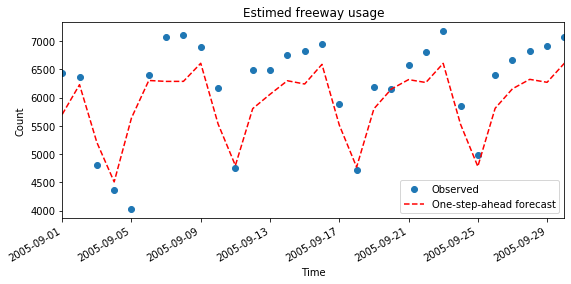

In [18]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Estimed freeway usage', xlabel='Time', ylabel='Count')

# Plot data points
test.plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.plot(ax=ax, style='r--', label='One-step-ahead forecast')

legend = ax.legend(loc='lower right')

In [19]:
from sklearn.metrics import mean_absolute_error

error = mean_absolute_error(test, predict)
print('Test Mean Absolute Error: {:0.3f}'.format(error))

Test Mean Absolute Error: 455.428


Voila! We have fit a SARIMA model to the data. Next step, we move away from the logically sound model to a more biological manner, by using artificial Neural Networks.

## LSTM
The next type of prediction we are going to do is to use Long-short tem predictions.